In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler

# Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)


# Ensure consistent data types and handle future warnings
pd.set_option('future.no_silent_downcasting', True)


In [2]:
# Load the data
raw_data = pd.read_csv('data/orders_export_1/orders_export_1.csv')

/var/folders/g3/y_p33x890117kpv5vtkgrkkr0000gn/T/ipykernel_53569/2011532045.py:2: DtypeWarning: Columns (20,28,52,56,72) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('data/orders_export_1/orders_export_1.csv')


## Data cleaning

In [3]:
raw_data.rename(columns={'Name': 'OrderID'}, inplace=True)

In [4]:
# Clean time columns 
time_col = ['Paid at', 'Fulfilled at', 'Created at']
for col in time_col:
    raw_data[col] = pd.to_datetime(raw_data[col].astype(str).str.split('+', expand=True)[0])


# Get data from 2024 onwards
df = raw_data[raw_data['Created at'].dt.year >= 2024]

In [5]:
# raw_data[raw_data['OrderID']=='#5893']

In [6]:
print("Old orders filtered count:", raw_data.shape[0] - df.shape[0])
print("Remaining orders count:", df.shape[0])

Old orders filtered count: 1142
Remaining orders count: 15535


## Tags definitions

**Faire-Wholesale** - orders that come through Faire (a different marketplace where we sell to B2B instead of B2C. As the pricing is different, I would recommend excluding this customers from your analysis)

**ReSell** - post purchase app we used for a period of time (but now we're back to using Recovert only). Post purchase means that that they get shown a product as an upsell at a discounted rate after placing their order, i.e. on the thank you page or at checkout etc etc

**Etsy** - I would exclude any Etsy customer from your analysis so it's solely focused on Shopify customers

**Loox** - Is the review app we use. It sends emails to customers to remind them to leave a review and uses incentives such as discounts (I can't remember on the top of my mind when they do this, e.g. if it's when asking for photos/videos) and reminds them about referrals.

**Current: pre-order** - as customer made the payment but the order gets shipped out later. We did this when we were out of stock on something but we no longer do this anymore.

**Online Store** - It's basically website, should be included

Exclude following tags:
1. Faire-Wholesale
2. Esty

In [7]:
df = df.copy()  # Ensure it's a fresh copy, not a slice
df['ExcludeTag'] = df['Tags'].str.contains('Faire|Etsy', case=False, na=False)


/var/folders/g3/y_p33x890117kpv5vtkgrkkr0000gn/T/ipykernel_53569/3120402333.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='pastel')


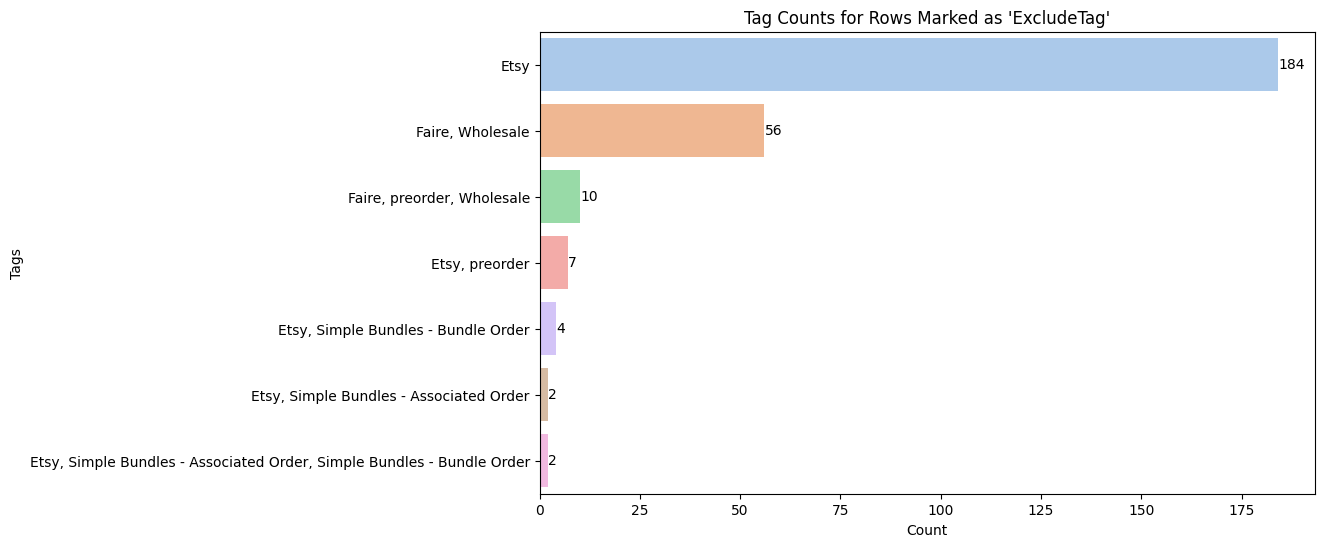

In [8]:
# Count the tags where 'ExcludeTag' is True
tag_counts = df[df['ExcludeTag'] == True]['Tags'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='pastel')

# Add annotations
for index, value in enumerate(tag_counts.values):
    plt.text(value + 0.1, index, str(value), va='center')

plt.title("Tag Counts for Rows Marked as 'ExcludeTag'")
plt.xlabel("Count")
plt.ylabel("Tags")
plt.show()

/var/folders/g3/y_p33x890117kpv5vtkgrkkr0000gn/T/ipykernel_53569/771157488.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='pastel')


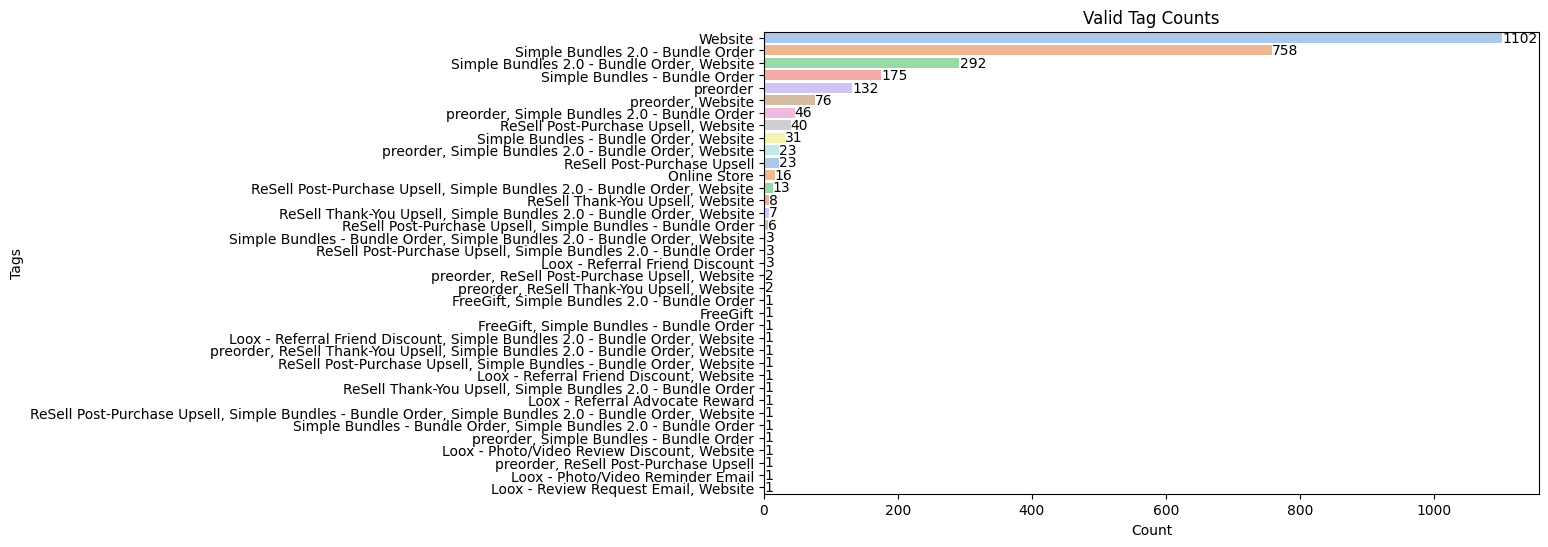

In [9]:
# Remaining valid tags
tag_counts = df[df['ExcludeTag'] == False]['Tags'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='pastel')

# Add annotations
for index, value in enumerate(tag_counts.values):
    plt.text(value + 0.1, index, str(value), va='center')

plt.title("Valid Tag Counts")
plt.xlabel("Count")
plt.ylabel("Tags")
plt.show()

In [10]:
# Define conditions and corresponding values
conditions = [
    df['Tags'].str.contains('ReSell', case=False, na=False),
    df['Tags'].str.contains('Loox', case=False, na=False)
]
values = ['ReSell', 'Loox']

# Apply conditions and rename the column to 'Sales Channel'
df['Sales Channel'] = np.select(conditions, values, default='Normal')

In [11]:
df['Sales Channel'].value_counts()

Sales Channel
Normal    15417
ReSell      109
Loox          9
Name: count, dtype: int64

In [12]:
# Dealing with multiple products under one order
# Under one OrderID, there's only first row of the product that has the correct information, others all Null, # e.g. OrderID #9948
# Solution: Fill missing values under the same OrderID with the first row's non-null values
for col in df.columns:
    df[col] = df.groupby('OrderID')[col].transform(lambda x: x.ffill().bfill())


### Create Bundle column
- Check if tags column contains any tex of "Bundle" 

*Note*

if a bundle is bought as an another product in a same order, especially not the first product, we cannot tell if this product is under a bundle.

This is one of the assumptions in this analysis. E.g. ProductID: #5893

In [13]:
# Create the 'Bundle' column to classify bundle orders
df['Bundle'] = df['Tags'].apply(lambda tag: 'Yes' if 'bundle' in str(tag).lower() else 'No')

In [14]:
df['Bundle'].value_counts()

Bundle
No     10611
Yes     4924
Name: count, dtype: int64

In [15]:
df[df['OrderID']=='#9948']

,OrderID,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,Taxes,Total,Discount Code,Discount Amount,Shipping Method,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem compare at price,Lineitem sku,Lineitem requires shipping,Lineitem taxable,Lineitem fulfillment status,Billing Name,Billing Street,Billing Address1,Billing Address2,Billing Company,Billing City,Billing Zip,Billing Province,Billing Country,Billing Phone,Shipping Name,Shipping Street,Shipping Address1,Shipping Address2,Shipping Company,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Shipping Phone,Notes,Note Attributes,Cancelled at,Payment Method,Payment Reference,Refunded Amount,Vendor,Id,Tags,Risk Level,Source,Lineitem discount,Tax 1 Name,Tax 1 Value,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,Duties,Billing Province Name,Shipping Province Name,Payment ID,Payment Terms Name,Next Payment Due At,Payment References,ExcludeTag,Sales Channel,Bundle
2,#9948,gavdncl@gmail.com,paid,2025-03-25 06:25:25,fulfilled,2025-03-25 08:02:09,no,GBP,76.5,9.5,14.33,86.0,NaN,0.0,Next Day Delivery,2025-03-25 06:25:24,1,Buttery Croissant Candle - Glass candle (165g),25.5,0.0,CND-BUC-G,True,True,fulfilled,Gavin Dugdale,"Fairway, Newcastle Road",Fairway,Newcastle Road,NaN,Durham,DH1 4HZ,ENG,GB,NaN,Gavin Dugdale,"Fairway, Newcastle road",Fairway,Newcastle road,NaN,Crossgate Moor,DH1 4HZ,ENG,GB,NaN,NaN,Currency rate: 1\nMarket: gb,NaN,Shopify Payments,rdvX9FdB9NrtT886IRwflWvAk,0.0,wickguru,1.167224e+13,Simple Bundles 2.0 - Bundle Order,Low,web,0.0,GB VAT 20%,14.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rdvX9FdB9NrtT886IRwflWvAk,NaN,NaN,rdvX9FdB9NrtT886IRwflWvAk,False,Normal,Yes
3,#9948,gavdncl@gmail.com,paid,2025-03-25 06:25:25,fulfilled,2025-03-25 08:02:09,no,GBP,76.5,9.5,14.33,86.0,NaN,0.0,Next Day Delivery,2025-03-25 06:25:24,1,Pistachio Macaron Candle - Glass candle (165g),25.5,0.0,CND-PIM-G,True,True,fulfilled,Gavin Dugdale,"Fairway, Newcastle Road",Fairway,Newcastle Road,NaN,Durham,DH1 4HZ,ENG,GB,NaN,Gavin Dugdale,"Fairway, Newcastle road",Fairway,Newcastle road,NaN,Crossgate Moor,DH1 4HZ,ENG,GB,NaN,NaN,Currency rate: 1\nMarket: gb,NaN,Shopify Payments,rdvX9FdB9NrtT886IRwflWvAk,0.0,wickguru,1.167224e+13,Simple Bundles 2.0 - Bundle Order,Low,web,0.0,GB VAT 20%,14.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rdvX9FdB9NrtT886IRwflWvAk,NaN,NaN,rdvX9FdB9NrtT886IRwflWvAk,False,Normal,Yes
4,#9948,gavdncl@gmail.com,paid,2025-03-25 06:25:25,fulfilled,2025-03-25 08:02:09,no,GBP,76.5,9.5,14.33,86.0,NaN,0.0,Next Day Delivery,2025-03-25 06:25:24,1,Baked Cookies Candle - Glass candle (165g),25.5,0.0,CND-BAC-G,True,True,fulfilled,Gavin Dugdale,"Fairway, Newcastle Road",Fairway,Newcastle Road,NaN,Durham,DH1 4HZ,ENG,GB,NaN,Gavin Dugdale,"Fairway, Newcastle road",Fairway,Newcastle road,NaN,Crossgate Moor,DH1 4HZ,ENG,GB,NaN,NaN,Currency rate: 1\nMarket: gb,NaN,Shopify Payments,rdvX9FdB9NrtT886IRwflWvAk,0.0,wickguru,1.167224e+13,Simple Bundles 2.0 - Bundle Order,Low,web,0.0,GB VAT 20%,14.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rdvX9FdB9NrtT886IRwflWvAk,NaN,NaN,rdvX9FdB9NrtT886IRwflWvAk,False,Normal,Yes


## Generate CustomerID
- Create a unique CustomerID based on Email, sorted by 'Created at' ascending order
- Earlier customers will have lower CustomerID starting from 1

In [16]:
# Create a unique CustomerID based on Email, sorted by 'Created at' ascending order
# Earlier customers will have lower CustomerID starting from 1
if 'Email' in df.columns and 'Created at' in df.columns:
    df = df.sort_values(by='Created at').reset_index(drop=True)
    unique_emails = df['Email'].unique()
    email_to_id = {email: idx + 1 for idx, email in enumerate(unique_emails)}
    df['CustomerID'] = df['Email'].map(email_to_id)

print("Customer unique count to date: ", df['CustomerID'].max())

Customer unique count to date:  7491


/var/folders/g3/y_p33x890117kpv5vtkgrkkr0000gn/T/ipykernel_53569/375081095.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='pastel')


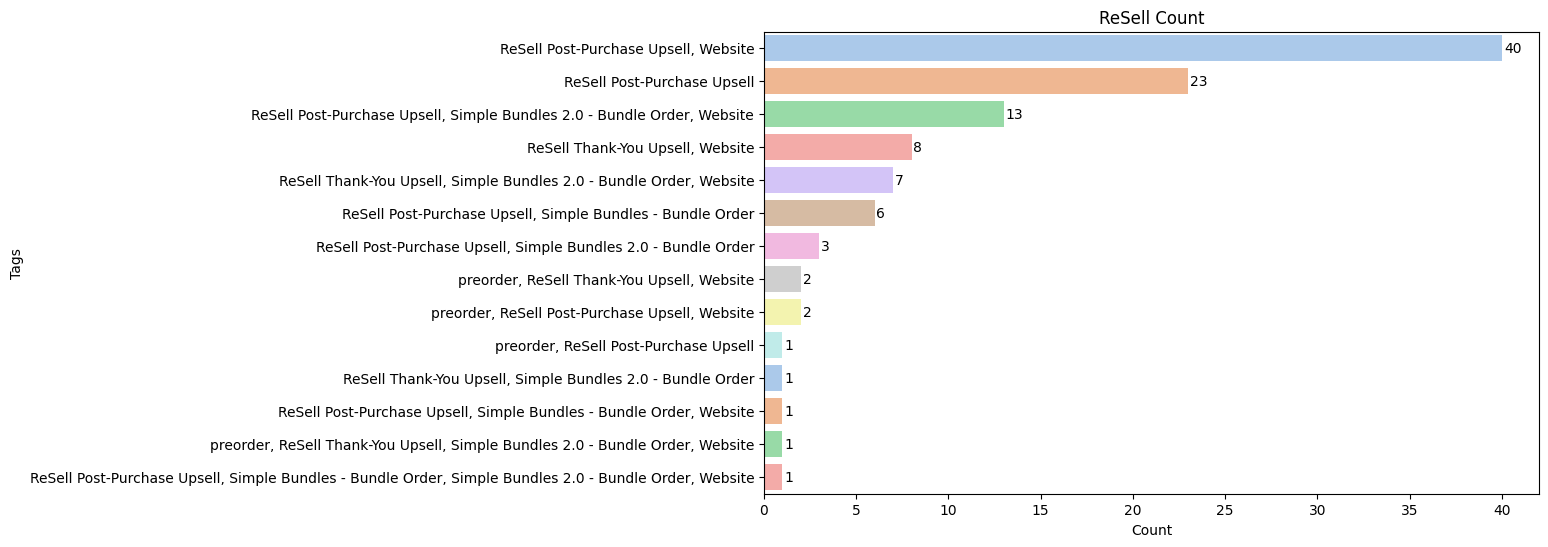

In [17]:
# Count the tags where 'ExcludeTag' is True
tag_counts = df[df['Sales Channel'] == 'ReSell']['Tags'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='pastel')

# Add annotations
for index, value in enumerate(tag_counts.values):
    plt.text(value + 0.1, index, str(value), va='center')

plt.title("ReSell Count")
plt.xlabel("Count")
plt.ylabel("Tags")
plt.show()

In [8]:
# Basic statistics
print("\nDescriptive statistics:\n", df.describe())


Descriptive statistics:
                              Paid at                   Fulfilled at  \
count                           8106                           8134   
mean   2024-09-09 02:47:46.040340480  2024-09-14 01:06:18.106097920   
min              2024-01-01 14:25:04            2024-01-03 13:08:52   
25%              2024-06-18 20:15:43            2024-06-20 20:54:28   
50%              2024-10-18 02:36:03            2024-10-21 10:26:30   
75%              2024-12-01 08:57:22  2024-12-11 13:15:51.249999872   
max              2025-03-25 09:25:20            2025-03-25 08:02:09   
std                              NaN                            NaN   

          Subtotal     Shipping        Taxes        Total  Discount Amount  \
count  8199.000000  8199.000000  8199.000000  8199.000000      8199.000000   
mean     42.072092     3.192076     0.263960    45.396053         4.139867   
min       0.000000     0.000000     0.000000     0.000000         0.000000   
25%      25.500000    

## Recurring Customer Definition
1. Purchase more than one order in the last 6 months
  - (More accurate timeframe should be defined by studying how often a customer comes back, for now this is good enough for version #1 for us to start)
2. If a customer purchase multiple orders in a day, it's consider one order, not recurring customer

In [70]:
df['Paid at date'] = df['Paid at'].dt.date

In [66]:
# Aggregate the data to per order level
# 1 orderID now corresponds to 1 row, sometimes it has multiple products under Lineitem quantity
# E.g. OrderID ##9936
agg_orders = df.groupby('OrderID').agg({'Email': 'max',
                           'CustomerID': 'max',
                           'Paid at': 'max',
                            'Fulfilled at': 'max',
                            'Created at': 'max',
                            'Cancelled at': 'max',
                            'Tags': 'max',
                            'Sales Channel': 'max',
                            'Bundle': 'max',
                            'Financial Status': 'max',
                            'Fulfillment Status': 'max',
                            'Lineitem quantity': 'sum',
                            'Discount Amount': 'mean',
                            'Total': 'mean',
                                        }).reset_index()

print("Total products count: ", agg_orders['Lineitem quantity'].sum())
print("Total orders count: ", agg_orders['OrderID'].shape[0])

Total products count:  17043
Total orders count:  8199


In [72]:
# agg_orders[agg_orders['OrderID'] == '#9936']

In [73]:
# Identify customers with multiple orders on the same day (Paid at shouldn't be null)
valid_orders = agg_orders[agg_orders['Financial Status'] == 'paid']
same_day_orders = valid_orders.groupby(
    ['CustomerID', valid_orders['Created at'].dt.date]).size().reset_index(name='OrderCount')
multiple_orders_same_day = same_day_orders[same_day_orders['OrderCount'] > 1]

print("\nCustomers with multiple orders on the same day:\n",
      multiple_orders_same_day)


Customers with multiple orders on the same day:
       CustomerID  Created at  OrderCount
4              5  2024-01-02           2
88            72  2024-07-21           2
750          645  2024-03-28           2
1692        1488  2024-06-11           2
1773        1561  2024-05-14           2
2160        1900  2024-06-17           2
2339        2051  2024-07-17           2
2535        2230  2024-07-07           2
2677        2364  2024-07-13           2
2754        2433  2024-07-15           2
2886        2555  2024-07-21           2
3215        2855  2024-08-03           2
3239        2875  2024-07-30           2
3348        2975  2024-08-03           2
4066        3637  2024-10-12           2
4126        3694  2024-10-14           2
4132        3698  2024-12-09           2
4472        4030  2024-10-25           2
5217        4749  2024-11-13           2
5943        5446  2024-11-29           2
6291        5794  2024-12-02           2
6327        5828  2025-03-06           2
6470   

In [74]:
multiple_orders_same_day['OrderCount'].sum()

np.int64(50)

In [75]:
agg_ordersa[agg_ordersa['CustomerID'] == 3698]

,OrderID,Paid at date,Email,CustomerID,Paid at,Fulfilled at,Created at,Cancelled at,Tags,Sales Channel,Bundle,Financial Status,Fulfillment Status,Lineitem quantity,Discount Amount,Total
3966,#5770,2024-10-14,kproctor89@gmail.com,3698,2024-10-14 18:14:31,2024-10-15 16:01:57,2024-10-14 18:14:31,NaN,Simple Bundles 2.0 - Bundle Order,Normal,Yes,paid,fulfilled,3,0.00,55.87
4627,#6441,2024-11-02,kproctor89@gmail.com,3698,2024-11-02 16:52:00,2024-11-19 02:31:48,2024-11-02 16:52:00,NaN,NaN,Normal,No,paid,fulfilled,3,0.00,90.37
5693,#7526,2024-11-28,kproctor89@gmail.com,3698,2024-11-28 17:37:01,2024-12-20 15:03:35,2024-11-28 17:37:01,NaN,NaN,Normal,No,partially_refunded,fulfilled,8,37.87,151.49
6668,#8505,2024-12-09,kproctor89@gmail.com,3698,2024-12-09 16:22:03,2024-12-11 09:32:52,2024-12-09 16:22:03,NaN,NaN,Normal,No,paid,fulfilled,2,0.00,44.59
6674,#8511,2024-12-09,kproctor89@gmail.com,3698,2024-12-09 18:23:49,2024-12-11 09:41:17,2024-12-09 18:23:46,NaN,NaN,Normal,No,paid,fulfilled,1,0.00,47.85


In [76]:
agg_orders[agg_orders['CustomerID'] == 3698]

,OrderID,Email,CustomerID,Paid at,Fulfilled at,Created at,Cancelled at,Tags,Sales Channel,Bundle,Financial Status,Fulfillment Status,Lineitem quantity,Discount Amount,Total
3995,#5770,kproctor89@gmail.com,3698,2024-10-14 18:14:31,2024-10-15 16:01:57,2024-10-14 18:14:31,NaN,Simple Bundles 2.0 - Bundle Order,Normal,Yes,paid,fulfilled,3,0.00,55.87
4659,#6441,kproctor89@gmail.com,3698,2024-11-02 16:52:00,2024-11-19 02:31:48,2024-11-02 16:52:00,NaN,NaN,Normal,No,paid,fulfilled,3,0.00,90.37
5725,#7526,kproctor89@gmail.com,3698,2024-11-28 17:37:01,2024-12-20 15:03:35,2024-11-28 17:37:01,NaN,NaN,Normal,No,partially_refunded,fulfilled,8,37.87,151.49
6703,#8505,kproctor89@gmail.com,3698,2024-12-09 16:22:03,2024-12-11 09:32:52,2024-12-09 16:22:03,NaN,NaN,Normal,No,paid,fulfilled,2,0.00,44.59
6709,#8511,kproctor89@gmail.com,3698,2024-12-09 18:23:49,2024-12-11 09:41:17,2024-12-09 18:23:46,NaN,NaN,Normal,No,paid,fulfilled,1,0.00,47.85


In [61]:
df[df['CustomerID'] == 3698]

,OrderID,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,Taxes,Total,Discount Code,Discount Amount,Shipping Method,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem compare at price,Lineitem sku,Lineitem requires shipping,Lineitem taxable,Lineitem fulfillment status,Billing Name,Billing Street,Billing Address1,Billing Address2,Billing Company,Billing City,Billing Zip,Billing Province,Billing Country,Billing Phone,Shipping Name,Shipping Street,Shipping Address1,Shipping Address2,Shipping Company,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Shipping Phone,Notes,Note Attributes,Cancelled at,Payment Method,Payment Reference,Refunded Amount,Vendor,Id,Tags,Risk Level,Source,Lineitem discount,Tax 1 Name,Tax 1 Value,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,Duties,Billing Province Name,Shipping Province Name,Payment ID,Payment Terms Name,Next Payment Due At,Payment References,ExcludeTag,Sales Channel,Bundle,CustomerID
7099,#5770,kproctor89@gmail.com,paid,2024-10-14 18:14:31,fulfilled,2024-10-15 16:01:57,no,GBP,44.22,11.65,0.0,55.87,NaN,0.00,Standard shipping,2024-10-14 18:14:31,1,Pain Au Chocolat Candle - Tin candle (90g),14.74,NaN,CND-PAA-T,True,True,fulfilled,Kristen Proctor,8063 Madison Ave,8063 Madison Ave,NaN,NaN,Indianapolis,'46227,IN,US,NaN,Kristen Proctor,"Carrer de Bonavista 6, Interior Principal 2",Carrer de Bonavista 6,Interior Principal 2,NaN,Barcelona,'08012,B,ES,NaN,NaN,Currency rate: 1.2211746\nMarket: europe\nvsly...,NaN,Shopify Payments,rYs83l1L2274dZbghvhLhhNO2,0.00,wickguru,6.117317e+12,Simple Bundles 2.0 - Bundle Order,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Indiana,Barcelona,rYs83l1L2274dZbghvhLhhNO2,NaN,NaN,rYs83l1L2274dZbghvhLhhNO2,False,Normal,Yes,3698
7100,#5770,kproctor89@gmail.com,paid,2024-10-14 18:14:31,fulfilled,2024-10-15 16:01:57,no,GBP,44.22,11.65,0.0,55.87,NaN,0.00,Standard shipping,2024-10-14 18:14:31,1,Roasted Coffee Candle - Tin candle (90g),14.74,NaN,CND-ROC-T,True,True,fulfilled,Kristen Proctor,8063 Madison Ave,8063 Madison Ave,NaN,NaN,Indianapolis,'46227,IN,US,NaN,Kristen Proctor,"Carrer de Bonavista 6, Interior Principal 2",Carrer de Bonavista 6,Interior Principal 2,NaN,Barcelona,'08012,B,ES,NaN,NaN,Currency rate: 1.2211746\nMarket: europe\nvsly...,NaN,Shopify Payments,rYs83l1L2274dZbghvhLhhNO2,0.00,wickguru,6.117317e+12,Simple Bundles 2.0 - Bundle Order,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Indiana,Barcelona,rYs83l1L2274dZbghvhLhhNO2,NaN,NaN,rYs83l1L2274dZbghvhLhhNO2,False,Normal,Yes,3698
7101,#5770,kproctor89@gmail.com,paid,2024-10-14 18:14:31,fulfilled,2024-10-15 16:01:57,no,GBP,44.22,11.65,0.0,55.87,NaN,0.00,Standard shipping,2024-10-14 18:14:31,1,Warm Sandalwood Candle - Tin candle (90g),14.74,NaN,CND-WAS-T,True,True,fulfilled,Kristen Proctor,8063 Madison Ave,8063 Madison Ave,NaN,NaN,Indianapolis,'46227,IN,US,NaN,Kristen Proctor,"Carrer de Bonavista 6, Interior Principal 2",Carrer de Bonavista 6,Interior Principal 2,NaN,Barcelona,'08012,B,ES,NaN,NaN,Currency rate: 1.2211746\nMarket: europe\nvsly...,NaN,Shopify Payments,rYs83l1L2274dZbghvhLhhNO2,0.00,wickguru,6.117317e+12,Simple Bundles 2.0 - Bundle Order,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Indiana,Barcelona,rYs83l1L2274dZbghvhLhhNO2,NaN,NaN,rYs83l1L2274dZbghvhLhhNO2,False,Normal,Yes,3698
8633,#6441,kproctor89@gmail.com,paid,2024-11-02 16:52:00,fulfilled,2024-11-19 02:31:48,no,GBP,78.68,11.69,0.0,90.37,NaN,0.00,Standard shipping,2024-11-02 16:52:00,1,Autumn Tealight Set | Try 8 Autumn Scents,30.98,NaN,CND-AUT-TEA,True,True,fulfilled,Kristen Proctor,8063 Madison Ave,8063 Madison Ave,NaN,NaN,Indianapolis,'46227,IN,US,NaN,Kristen Proctor,"Carrer de Bonavista 6, Interior Principal 2",Carrer de Bonavista 6,Interior Principal 2,NaN,Barcelona,'08012,B,ES,NaN,NaN,Currency rate: 1.2167172\nMarket: europe\nvsly.

In [ ]:

# Calculate Recency, Frequency, Monetary (RFM) values
rfm = df.groupby('CustomerID').agg({
    'Paid at': lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days,
    'OrderID': 'count',
    'Total': 'sum'
}).rename(columns={
    'Paid at': 'Recency',
    'OrderID': 'Frequency',
    'Total': 'Monetary'
})

In [11]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
1,449.0,1,15.50
2,449.0,1,57.50
3,448.0,1,28.90
4,448.0,1,16.90
5,448.0,2,57.80
...,...,...,...
7487,0.0,1,51.20
7488,0.0,6,86.40
7489,0.0,3,86.00


In [12]:
df[df['CustomerID']==5]

,OrderID,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,Taxes,Total,Discount Code,Discount Amount,Shipping Method,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem compare at price,Lineitem sku,Lineitem requires shipping,Lineitem taxable,Lineitem fulfillment status,Billing Name,Billing Street,Billing Address1,Billing Address2,Billing Company,Billing City,Billing Zip,Billing Province,Billing Country,Billing Phone,Shipping Name,Shipping Street,Shipping Address1,Shipping Address2,Shipping Company,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Shipping Phone,Notes,Note Attributes,Cancelled at,Payment Method,Payment Reference,Refunded Amount,Vendor,Id,Tags,Risk Level,Source,Lineitem discount,Tax 1 Name,Tax 1 Value,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,Duties,Billing Province Name,Shipping Province Name,Payment ID,Payment Terms Name,Next Payment Due At,Payment References,CustomerID
4,#1756,gmaloney23@gmail.com,paid,2024-01-02 14:49:57,fulfilled,2024-01-03 13:08:56,no,GBP,26.0,2.9,0.0,28.9,NaN,0.0,Standard,2024-01-02 14:49:57,1,Sailing Day Candle | Bergamot + Marine + Moss ...,26.0,0.0,NaN,True,False,fulfilled,Grace Maloney,"20 the crescent, Frinton on sea",20 the crescent,Frinton on sea,NaN,Essex,CO13 9AP,ENG,GB,07837 859340,Grace Maloney,"20 The Crescent, Frinton-on-sea",20 The Crescent,Frinton-on-sea,NaN,Essex,CO13 9AP,ENG,GB,NaN,NaN,"sra_identifiers: {""general"":{},""google_analyti...",NaN,Shopify Payments,rZai6loeDQ8E6XrqB6fBrPnxj,0.0,wickguru,5.697766e+12,NaN,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rZai6loeDQ8E6XrqB6fBrPnxj,NaN,NaN,rZai6loeDQ8E6XrqB6fBrPnxj,5
5,#1757,gmaloney23@gmail.com,paid,2024-01-02 14:53:16,fulfilled,2024-01-03 13:08:57,no,GBP,26.0,2.9,0.0,28.9,NaN,0.0,Standard,2024-01-02 14:53:15,1,Zen Candle | Green Tea + Cassis + Amber - Glas...,26.0,0.0,NaN,True,True,fulfilled,Grace Maloney,"20 the crescent, Frinton on sea",20 the crescent,Frinton on sea,NaN,Essex,CO13 9AP,ENG,GB,07837 859340,Grace Maloney,"20 The Crescent, Frinton-on-sea",20 The Crescent,Frinton-on-sea,NaN,Essex,CO13 9AP,ENG,GB,NaN,NaN,"sra_identifiers: {""general"":{},""google_analyti...",NaN,Shopify Payments,rUwgDQ3WlwKtCc6HKFVmbo4SG,0.0,wickguru,5.697769e+12,NaN,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rUwgDQ3WlwKtCc6HKFVmbo4SG,NaN,NaN,rUwgDQ3WlwKtCc6HKFVmbo4SG,5


In [41]:
# Identify customers with multiple orders on the same day (Paid at shouldn't be null)
valid_orders = df[df['Financial Status']=='paid']
same_day_orders = valid_orders.groupby(['CustomerID', valid_orders['Created at'].dt.date]).size().reset_index(name='OrderCount')
multiple_orders_same_day = same_day_orders[same_day_orders['OrderCount'] > 1]

print("\nCustomers with multiple orders on the same day:\n", multiple_orders_same_day)



Customers with multiple orders on the same day:
       CustomerID  Created at  OrderCount
4              5  2024-01-02           2
88            72  2024-07-21           2
750          645  2024-03-28           2
1692        1488  2024-06-11           2
1773        1561  2024-05-14           2
2160        1900  2024-06-17           2
2339        2051  2024-07-17           2
2535        2230  2024-07-07           2
2677        2364  2024-07-13           2
2754        2433  2024-07-15           2
2886        2555  2024-07-21           2
3215        2855  2024-08-03           2
3239        2875  2024-07-30           2
3348        2975  2024-08-03           2
4066        3637  2024-10-12           2
4126        3694  2024-10-14           2
4132        3698  2024-12-09           2
4472        4030  2024-10-25           2
5217        4749  2024-11-13           2
5943        5446  2024-11-29           2
6291        5794  2024-12-02           2
6327        5828  2025-03-06           2
6470   

In [42]:
df[df['CustomerID']==72].sort_values(by='Paid at')

,OrderID,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,Taxes,Total,Discount Code,Discount Amount,Shipping Method,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem compare at price,Lineitem sku,Lineitem requires shipping,Lineitem taxable,Lineitem fulfillment status,Billing Name,Billing Street,Billing Address1,Billing Address2,Billing Company,Billing City,Billing Zip,Billing Province,Billing Country,Billing Phone,Shipping Name,Shipping Street,Shipping Address1,Shipping Address2,Shipping Company,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Shipping Phone,Notes,Note Attributes,Cancelled at,Payment Method,Payment Reference,Refunded Amount,Vendor,Id,Tags,Risk Level,Source,Lineitem discount,Tax 1 Name,Tax 1 Value,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,Duties,Billing Province Name,Shipping Province Name,Payment ID,Payment Terms Name,Next Payment Due At,Payment References,CustomerID
84,#1827,o.nichollsbates@outlook.com,paid,2024-01-17 14:02:00,fulfilled,2024-01-18 12:45:33,no,GBP,42.24,2.90,0.0,45.14,COSYHOME,7.46,Standard,2024-01-17 14:00:12,1,Build Your Own Candle Bundle - Tin,35.7,42.0,NaN,True,True,fulfilled,Olivia Nicholls Bates,5 Rother Close,5 Rother Close,NaN,NaN,Crowborough,TN6 3AY,ENG,GB,NaN,Olivia Nicholls Bates,5 Rother Close,5 Rother Close,NaN,NaN,Crowborough,TN6 3AY,ENG,GB,NaN,NaN,"sra_identifiers: {""general"":{},""google_analyti...",NaN,Shopify Payments,rHIfpj3XlMMiKNqSISviGIzD2,0.0,Wick Guru,5.717286e+12,NaN,Low,web,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,r0aJSlrUmGuNvA9PUR8N207Uj + rHIfpj3XlMMiKNqSIS...,NaN,NaN,r0aJSlrUmGuNvA9PUR8N207Uj + rHIfpj3XlMMiKNqSIS...,72
2397,#3440,o.nichollsbates@outlook.com,paid,2024-05-18 12:33:04,fulfilled,2024-05-20 12:39:21,yes,GBP,42.00,0.00,0.0,42.00,1STBDAY,14.00,Standard,2024-05-18 12:33:04,1,Baked Cookies Candle | Butter + Vanilla + Suga...,14.0,0.0,NaN,True,True,fulfilled,Olivia Nicholls Bates,5 Rother Close,5 Rother Close,NaN,NaN,Crowborough,TN6 3AY,ENG,GB,NaN,Olivia Nicholls Bates,5 Rother Close,5 Rother Close,NaN,NaN,Crowborough,TN6 3AY,ENG,GB,NaN,NaN,NaN,NaN,Shopify Payments,r0jBGGzUpARsMIZM0HEFxJTB8,0.0,wickguru,5.927101e+12,NaN,Low,web,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,r0jBGGzUpARsMIZM0HEFxJTB8,NaN,NaN,r0jBGGzUpARsMIZM0HEFxJTB8,72
4546,#4513,o.nichollsbates@outlook.com,paid,2024-07-21 14:16:03,fulfilled,2024-08-02 13:13:37,yes,GBP,35.80,3.99,0.0,39.79,524fadfcc36f,18.00,Standard,2024-07-21 14:14:50,1,Sea Salt Candle | Sea Salt + Sandalwood + Ambe...,12.6,0.0,CND-SES-T,True,True,fulfilled,Olivia Nicholls Bates,5 Rother Close,5 Rother Close,NaN,NaN,Crowborough,TN6 3AY,ENG,GB,NaN,Olivia Nicholls Bates,5 Rother Close,5 Rother Close,NaN,NaN,Crowborough,TN6 3AY,ENG,GB,NaN,NaN,NaN,NaN,Shopify Payments,rMkEge3snDTaC6d2cJEw0S6TS,0.0,wickguru,6.007643e+12,ReSell Post-Purchase Upsell- Simple Bundles 2....,Low,web,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rhlzM9C3Y6771yHaCQIzCJH57 + rMkEge3snDTaC6d2cJ...,NaN,NaN,rj28mbJzGZcKvfiZbeuoD2J4k + rhlzM9C3Y6771yHaCQ...,72
4549,#4514,o.nichollsbates@outlook.com,paid,2024-07-21 14:27:09,fulfilled,2024-08-02 13:13:38,yes,GBP,44.72,3.99,0.0,48.71,SNUGVIBES,14.48,Standard,2024-07-21 14:26:12,2,Baked Cookies Candle | Butter + Vanilla + Suga...,14.4,0.0,CND-BAC-T,True,True,fulfilled,Olivia Nicholls Bates,5 Rother Close,5 Rother Close,NaN,NaN,Crowborough,TN6 3AY,ENG,GB,NaN,Olivia Nicholls Bates,5 Rother Close,5 Rother Close,NaN,NaN,Crowborough,TN6 3AY,ENG,GB,NaN,NaN,NaN,NaN,Shopify Payments,ri4O9AhSncVxUY6hz2EyajvRJ,0.0,wickguru,6.007655e+12,ReSell Post-Purchase Upsell- Simple Bundles 2....,Low,web,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rViHgkNHbFtogvh8DaunXzXsI + ri4O9AhSncVxUY6hz2...,NaN,NaN,rViHgkNHbFtogvh8DaunXzXsI + ri4O9AhSncVxUY6hz2...,72
15060

In [23]:
df[df['Tags']=='Simple Bundles 2.0 - Bundle Order'].sort_values('OrderID').head(5)

,OrderID,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,Taxes,Total,Discount Code,Discount Amount,Shipping Method,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem compare at price,Lineitem sku,Lineitem requires shipping,Lineitem taxable,Lineitem fulfillment status,Billing Name,Billing Street,Billing Address1,Billing Address2,Billing Company,Billing City,Billing Zip,Billing Province,Billing Country,Billing Phone,Shipping Name,Shipping Street,Shipping Address1,Shipping Address2,Shipping Company,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Shipping Phone,Notes,Note Attributes,Cancelled at,Payment Method,Payment Reference,Refunded Amount,Vendor,Id,Tags,Risk Level,Source,Lineitem discount,Tax 1 Name,Tax 1 Value,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,Duties,Billing Province Name,Shipping Province Name,Payment ID,Payment Terms Name,Next Payment Due At,Payment References,CustomerID
1082,#2554,humchuhan@gmail.com,paid,2024-04-03 20:33:37,fulfilled,2024-04-05 18:39:35,yes,GBP,32.13,2.9,0.0,35.03,SNUGVIBES,5.67,Standard,2024-04-03 20:33:37,1,Baked Cookies Candle | Butter + Vanilla + Suga...,12.6,0.0,NaN,True,True,fulfilled,Humaira Chuhan,"7 Cedar Road, Cranford",7 Cedar Road,Cranford,NaN,Hounslow,TW4 7QL,ENG,GB,07463207227,Humaira Chuhan,"7 Cedar Road, Cranford",7 Cedar Road,Cranford,NaN,Hounslow,TW4 7QL,ENG,GB,07463207227,NaN,__prq_response_id: E8TM3jEW\n__prq_quiz_id: og...,NaN,Shopify Payments,rdByx1XSd1K1hU8cJIG4SN6LD,0.0,wickguru,5.860801e+12,Simple Bundles 2.0 - Bundle Order,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rdByx1XSd1K1hU8cJIG4SN6LD,NaN,NaN,rdByx1XSd1K1hU8cJIG4SN6LD,767
1089,#2559,lnwhitmore@gmail.com,paid,2024-04-04 08:09:39,fulfilled,2024-04-05 19:09:36,no,GBP,37.80,2.9,0.0,40.70,NaN,0.00,Standard,2024-04-04 08:09:39,1,Buttery Croissant Candle | Milk + Butter + Van...,12.6,0.0,NaN,True,True,fulfilled,Louise Whitmore,"Flat 7 Robert Owen House, Baroness Road",Flat 7 Robert Owen House,Baroness Road,NaN,London,E2 7PN,ENG,GB,NaN,Louise Whitmore,"Flat 7 Robert Owen House, Baroness Road",Flat 7 Robert Owen House,Baroness Road,NaN,London,E2 7PN,ENG,GB,NaN,NaN,NaN,NaN,Shopify Payments,rzyThuVvi6YOk2AFQB40ATKja,0.0,wickguru,5.861329e+12,Simple Bundles 2.0 - Bundle Order,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rzyThuVvi6YOk2AFQB40ATKja,NaN,NaN,rzyThuVvi6YOk2AFQB40ATKja,772
1098,#2565,jade_lefevre@outlook.com,paid,2024-04-04 16:10:42,fulfilled,2024-04-05 19:09:38,yes,GBP,59.67,0.0,0.0,59.67,BA-b79242e21373,6.63,Standard,2024-04-04 16:10:41,1,Buttery Croissant Candle | Milk + Butter + Van...,22.1,0.0,NaN,True,True,fulfilled,Jade Lefevre,"34, Coleshill Street",34,Coleshill Street,NaN,Sutton Coldfield,B72 1SH,ENG,GB,+447840145494,Jade Lefevre,"34, Coleshill Street",34,Coleshill Street,NaN,Sutton Coldfield,B72 1SH,ENG,GB,+447840145494,NaN,NaN,NaN,Shopify Payments,rfeL0ylxSNLN0WbhJaROw6luB,0.0,wickguru,5.861715e+12,Simple Bundles 2.0 - Bundle Order,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rfeL0ylxSNLN0WbhJaROw6luB,NaN,NaN,rfeL0ylxSNLN0WbhJaROw6luB,778
1101,#2567,oliguy1987@hotmail.co.uk,paid,2024-04-04 16:58:10,fulfilled,2024-04-05 19:09:42,yes,GBP,59.67,0.0,0.0,59.67,BA-de0edaaaf262,6.63,Standard,2024-04-04 16:58:09,1,Buttery Croissant Candle | Milk + Butter + Van...,22.1,0.0,NaN,True,True,fulfilled,Oli Guy,5 HIPLEY STREET,5 HIPLEY STREET,NaN,NaN,WOKING,GU22 9LQ,ENG,GB,NaN,Oli Guy,5 HIPLEY STREET,5 HIPLEY STREET,NaN,NaN,WOKING,GU22 9LQ,ENG,GB,NaN,NaN,NaN,NaN,Shopify Payments,rZPC7E7cQkxevEEivaqNRPqO2,0.0,wickguru,5.861770e+12,Simple Bundles 2.0 - Bundle Order,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rZPC7E7cQkxevEEivaqNRPqO2,NaN,NaN,rZPC7E7cQkxevEEivaqNRPqO2,780
1117,#2577,hazzlewis@hotmail.co.uk,paid,2024-04-05 00:2

In [25]:
df[df['OrderID']=='#2554']

,OrderID,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,Taxes,Total,Discount Code,Discount Amount,Shipping Method,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem compare at price,Lineitem sku,Lineitem requires shipping,Lineitem taxable,Lineitem fulfillment status,Billing Name,Billing Street,Billing Address1,Billing Address2,Billing Company,Billing City,Billing Zip,Billing Province,Billing Country,Billing Phone,Shipping Name,Shipping Street,Shipping Address1,Shipping Address2,Shipping Company,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Shipping Phone,Notes,Note Attributes,Cancelled at,Payment Method,Payment Reference,Refunded Amount,Vendor,Id,Tags,Risk Level,Source,Lineitem discount,Tax 1 Name,Tax 1 Value,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,Duties,Billing Province Name,Shipping Province Name,Payment ID,Payment Terms Name,Next Payment Due At,Payment References,CustomerID
1080,#2554,humchuhan@gmail.com,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-03 20:33:37,1,Vintage Bookstore Candle | Pepper + Violet + P...,12.6,0.0,NaN,True,True,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wickguru,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,767
1081,#2554,humchuhan@gmail.com,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-03 20:33:37,1,Midnight Rose Candle | Rose + White Musk + Oud...,12.6,0.0,NaN,True,True,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wickguru,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,767
1082,#2554,humchuhan@gmail.com,paid,2024-04-03 20:33:37,fulfilled,2024-04-05 18:39:35,yes,GBP,32.13,2.9,0.0,35.03,SNUGVIBES,5.67,Standard,2024-04-03 20:33:37,1,Baked Cookies Candle | Butter + Vanilla + Suga...,12.6,0.0,NaN,True,True,fulfilled,Humaira Chuhan,"7 Cedar Road, Cranford",7 Cedar Road,Cranford,NaN,Hounslow,TW4 7QL,ENG,GB,07463207227,Humaira Chuhan,"7 Cedar Road, Cranford",7 Cedar Road,Cranford,NaN,Hounslow,TW4 7QL,ENG,GB,07463207227,NaN,__prq_response_id: E8TM3jEW\n__prq_quiz_id: og...,NaN,Shopify Payments,rdByx1XSd1K1hU8cJIG4SN6LD,0.0,wickguru,5.860801e+12,Simple Bundles 2.0 - Bundle Order,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rdByx1XSd1K1hU8cJIG4SN6LD,NaN,NaN,rdByx1XSd1K1hU8cJIG4SN6LD,767


In [34]:
duplicate_orders = df.groupby('OrderID').size().reset_index(name='Count')
duplicate_orders = duplicate_orders[duplicate_orders['Count'] > 1]
print(duplicate_orders)

          OrderID  Count
12          #1764      2
25          #1777      2
26          #1778      2
35          #1787      2
51          #1803      2
...           ...    ...
8194  #Z67D5KW9BF      3
8195  #ZMRYEGMZUP      5
8196  #ZQWU9TYZP7      3
8197  #ZSSQV4RTWJ      4
8198  #ZZXJUGT5MR      5

[3674 rows x 2 columns]


In [40]:
df[df['OrderID']=='#3770']

,OrderID,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,Taxes,Total,Discount Code,Discount Amount,Shipping Method,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem compare at price,Lineitem sku,Lineitem requires shipping,Lineitem taxable,Lineitem fulfillment status,Billing Name,Billing Street,Billing Address1,Billing Address2,Billing Company,Billing City,Billing Zip,Billing Province,Billing Country,Billing Phone,Shipping Name,Shipping Street,Shipping Address1,Shipping Address2,Shipping Company,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Shipping Phone,Notes,Note Attributes,Cancelled at,Payment Method,Payment Reference,Refunded Amount,Vendor,Id,Tags,Risk Level,Source,Lineitem discount,Tax 1 Name,Tax 1 Value,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,Duties,Billing Province Name,Shipping Province Name,Payment ID,Payment Terms Name,Next Payment Due At,Payment References,CustomerID
2992,#3770,pietrastoneworks@gmail.com,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-06-16 16:41:45,1,Baked Cookies Candle | Butter + Vanilla + Suga...,14.0,0.0,CND-BAC-T,True,True,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wickguru,NaN,NaN,NaN,NaN,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1885
2993,#3770,pietrastoneworks@gmail.com,paid,2024-06-16 16:42:06,fulfilled,2024-06-17 13:06:28,no,GBP,23.8,3.99,0.0,27.79,NaN,4.2,Standard,2024-06-16 16:41:45,1,Buttery Croissant Candle | Milk + Butter + Van...,14.0,0.0,CND-BUC-T,True,True,fulfilled,Jamie Stenning,"33, 10 Belmont Road","33, 10 Belmont Road",NaN,NaN,Wallington,SM6 8TE,ENG,GB,NaN,Jamie Stenning,"33, 10 Belmont Road","33, 10 Belmont Road",NaN,NaN,Wallington,SM6 8TE,ENG,GB,NaN,NaN,NaN,NaN,Shopify Payments,rCl8eyFC3gjjB4jzQxiI9k6jE,0.0,wickguru,5.963795e+12,ReSell Post-Purchase Upsell- Website,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rYqtFbUmXPvn0BDa3SH2JzicB + rCl8eyFC3gjjB4jzQx...,NaN,NaN,rYqtFbUmXPvn0BDa3SH2JzicB + rCl8eyFC3gjjB4jzQx...,1885


In [26]:
df['Tags'].value_counts().to_csv('tags.csv')

In [28]:
df['Tags'] = df['Tags'].str.replace(',', '-', regex=False)
tags = df['Tags'].value_counts()

In [30]:
tags.to_csv('tags.csv')